## Importing libraries

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [63]:
adata = sc.read_10x_mtx(path='/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW/GSM7841481_P5', prefix='GSM7841481_P5_')
adata

AnnData object with n_obs × n_vars = 12195 × 36601
    var: 'gene_ids', 'feature_types'

In [64]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')

In [65]:
adata

AnnData object with n_obs × n_vars = 12195 × 2000
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

## Doublet Removal

In [72]:
sc.pp.filter_cells(adata, min_genes=50)

In [73]:
adata

AnnData object with n_obs × n_vars = 11575 × 1124
    obs: '_scvi_batch', '_scvi_labels', 'n_genes'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [74]:
adata.var.isnull().any()

gene_ids                False
feature_types           False
highly_variable         False
highly_variable_rank    False
means                   False
variances               False
variances_norm          False
n_cells                 False
dtype: bool

In [75]:
import scvi.model

scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 400/400: 100%|██████████| 400/400 [05:44<00:00,  1.09it/s, v_num=1, train_loss_step=454, train_loss_epoch=464]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:44<00:00,  1.16it/s, v_num=1, train_loss_step=454, train_loss_epoch=464]


In [76]:
adata.X

<11575x1124 sparse matrix of type '<class 'numpy.float32'>'
	with 1735671 stored elements in Compressed Sparse Column format>

In [77]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 204/400:  51%|█████     | 204/400 [00:43<00:41,  4.67it/s, v_num=1, train_loss_step=0.343, train_loss_epoch=0.288]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.277. Signaling Trainer to stop.


In [78]:
df = solo.predict()
df['prediction'] = solo.predict(soft=False)

df

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACCTGAGAAGGTTT-1,0.242863,0.757137,singlet
AAACCTGAGAATTGTG-1,0.000203,0.999798,singlet
AAACCTGAGCGAGAAA-1,0.441163,0.558837,singlet
AAACCTGAGGTGCAAC-1,0.014014,0.985986,singlet
AAACCTGAGGTGCACA-1,0.729746,0.270254,doublet
...,...,...,...
TTTGTCATCCGCAAGC-1,0.020418,0.979582,singlet
TTTGTCATCCGTTGTC-1,0.335384,0.664616,singlet
TTTGTCATCGCAGGCT-1,0.021091,0.978909,singlet
TTTGTCATCTATCCCG-1,0.232671,0.767329,singlet


In [79]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,2714,2714
singlet,8861,8861


In [80]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
AAACCTGAGAAGGTTT-1,0.242863,0.757137,singlet,-0.514275
AAACCTGAGAATTGTG-1,0.000203,0.999798,singlet,-0.999595
AAACCTGAGCGAGAAA-1,0.441163,0.558837,singlet,-0.117674
AAACCTGAGGTGCAAC-1,0.014014,0.985986,singlet,-0.971972
AAACCTGAGGTGCACA-1,0.729746,0.270254,doublet,0.459492
...,...,...,...,...
TTTGTCATCCGCAAGC-1,0.020418,0.979582,singlet,-0.959163
TTTGTCATCCGTTGTC-1,0.335384,0.664616,singlet,-0.329232
TTTGTCATCGCAGGCT-1,0.021091,0.978909,singlet,-0.957818
TTTGTCATCTATCCCG-1,0.232671,0.767329,singlet,-0.534658


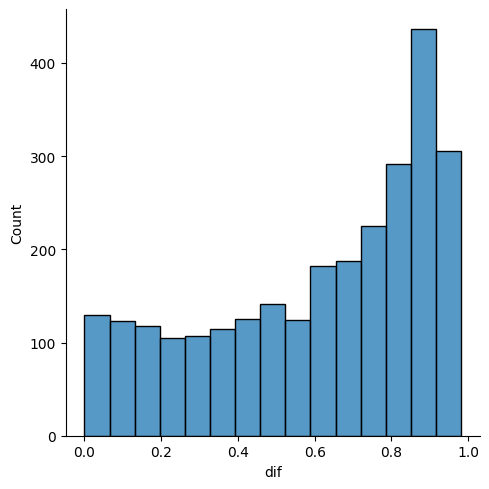

In [81]:
import seaborn as sns

sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [84]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.8)]
doublets.shape

(977, 4)

In [85]:
adata = sc.read_10x_mtx(path='/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW/GSM7841481_P5', prefix='GSM7841481_P5_')

adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]

adata

View of AnnData object with n_obs × n_vars = 11218 × 36601
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

## Data preprocessing

In [86]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var

/var/folders/cc/zxztq5d10436scg1c7f92bkr0000gn/T/ipykernel_40121/3248256402.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


,gene_ids,feature_types,mt
MIR1302-2HG,ENSG00000243485,Gene Expression,False
FAM138A,ENSG00000237613,Gene Expression,False
OR4F5,ENSG00000186092,Gene Expression,False
AL627309.1,ENSG00000238009,Gene Expression,False
AL627309.3,ENSG00000239945,Gene Expression,False
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,False
AC023491.2,ENSG00000278633,Gene Expression,False
AC007325.1,ENSG00000276017,Gene Expression,False
AC007325.4,ENSG00000278817,Gene Expression,False


In [87]:
ribo_path = "/Users/yashasappaji/Desktop/projects/single_cell/Datasets/KEGG_RIBOSOME.v2023.2.Hs.txt"
ribo_genes = pd.read_table(ribo_path, skiprows=2, header=None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [88]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [89]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCTGAGAAGGTTT-1,False,1779,3946.0,148.0,3.750633,779.0,19.741510
AAACCTGAGAATTGTG-1,False,1115,2056.0,130.0,6.322957,395.0,19.212063
AAACCTGAGCGAGAAA-1,False,1819,5954.0,114.0,1.914679,2605.0,43.752098
AAACCTGAGCTACCTA-1,False,560,1122.0,239.0,21.301247,6.0,0.534759
AAACCTGAGGTGCAAC-1,False,1228,2509.0,69.0,2.750100,542.0,21.602232
...,...,...,...,...,...,...,...
TTTGTCATCCGTTGTC-1,False,1839,4029.0,75.0,1.861504,886.0,21.990568
TTTGTCATCGCAGGCT-1,False,1659,3118.0,84.0,2.694035,686.0,22.001284
TTTGTCATCTATCCCG-1,False,1184,2985.0,103.0,3.450586,1027.0,34.405361
TTTGTCATCTCGAGTA-1,False,1297,2454.0,95.0,3.871231,562.0,22.901386


In [90]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False,0,0.000000,100.000000,0.0
C10orf99,ENSG00000188373,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL390786.1,ENSG00000233258,Gene Expression,False,False,0,0.000000,100.000000,0.0
AC069540.2,ENSG00000286876,Gene Expression,False,False,0,0.000000,100.000000,0.0
LINC02650,ENSG00000233945,Gene Expression,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
MT-CYB,ENSG00000198727,Gene Expression,True,False,11015,11.672847,1.809592,130946.0
MALAT1,ENSG00000251562,Gene Expression,False,False,11092,59.417542,1.123195,666546.0
MT-CO3,ENSG00000198938,Gene Expression,True,False,11094,14.966125,1.105366,167890.0
MT-CO2,ENSG00000198712,Gene Expression,True,False,11141,21.633802,0.686397,242688.0


In [91]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AC007325.4,ENSG00000278817,Gene Expression,False,False,3,0.000267,99.973257,3.0,3
DDN,ENSG00000181418,Gene Expression,False,False,3,0.000267,99.973257,3.0,3
PRPH,ENSG00000135406,Gene Expression,False,False,3,0.000267,99.973257,3.0,3
SP7,ENSG00000170374,Gene Expression,False,False,3,0.000267,99.973257,3.0,3
ASCL5,ENSG00000232237,Gene Expression,False,False,3,0.000267,99.973257,3.0,3
...,...,...,...,...,...,...,...,...,...
MT-CYB,ENSG00000198727,Gene Expression,True,False,11015,11.672847,1.809592,130946.0,11015
MALAT1,ENSG00000251562,Gene Expression,False,False,11092,59.417542,1.123195,666546.0,11092
MT-CO3,ENSG00000198938,Gene Expression,True,False,11094,14.966125,1.105366,167890.0,11094
MT-CO2,ENSG00000198712,Gene Expression,True,False,11141,21.633802,0.686397,242688.0,11141


In [92]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTAGGCAGCGATAGC-1,False,17,917.0,900.0,98.146126,0.0,0.000000
TGATTTCGTCCGAACC-1,False,29,523.0,487.0,93.116638,4.0,0.764818
AGCGTATTCATAACCG-1,False,30,676.0,620.0,91.715973,4.0,0.591716
CGTTAGAGTGATGCCC-1,False,32,812.0,776.0,95.566505,1.0,0.123153
GTACGTATCTCCAACC-1,False,33,663.0,600.0,90.497742,8.0,1.206637
...,...,...,...,...,...,...,...
CTCACACCATTAGCCA-1,False,5366,22543.0,851.0,3.775008,3199.0,14.190658
TACAGTGGTAAGCACG-1,False,5525,24726.0,699.0,2.826984,2648.0,10.709374
TACTTACTCTAACTCT-1,False,5801,28495.0,965.0,3.386559,4518.0,15.855413
TACTCGCTCACCGGGT-1,False,5865,29487.0,865.0,2.933496,5438.0,18.442026


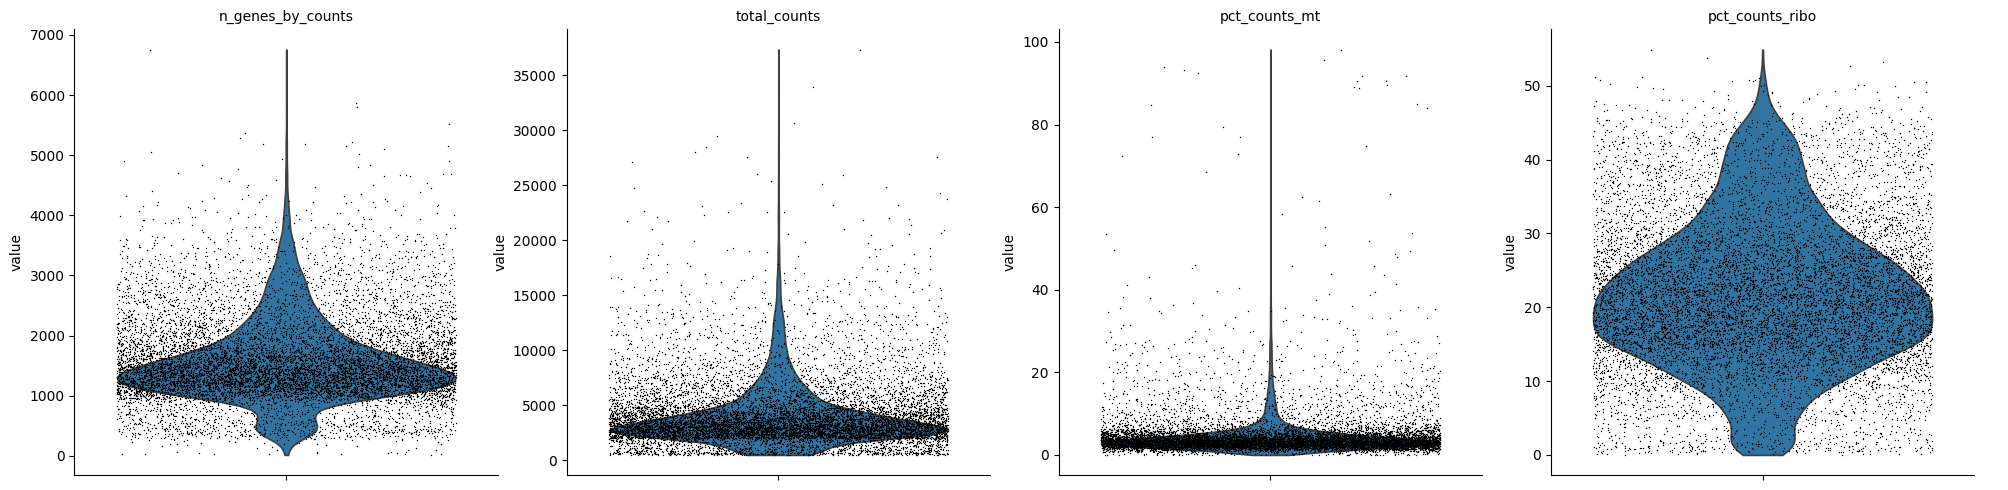

In [93]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [94]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCTGAGAAGGTTT-1,False,1779,3946.0,148.0,3.750633,779.0,19.741510
AAACCTGAGAATTGTG-1,False,1115,2056.0,130.0,6.322957,395.0,19.212063
AAACCTGAGCGAGAAA-1,False,1819,5954.0,114.0,1.914679,2605.0,43.752098
AAACCTGAGCTACCTA-1,False,560,1122.0,239.0,21.301247,6.0,0.534759
AAACCTGAGGTGCAAC-1,False,1228,2509.0,69.0,2.750100,542.0,21.602232
...,...,...,...,...,...,...,...
TTTGTCATCCGTTGTC-1,False,1839,4029.0,75.0,1.861504,886.0,21.990568
TTTGTCATCGCAGGCT-1,False,1659,3118.0,84.0,2.694035,686.0,22.001284
TTTGTCATCTATCCCG-1,False,1184,2985.0,103.0,3.450586,1027.0,34.405361
TTTGTCATCTCGAGTA-1,False,1297,2454.0,95.0,3.871231,562.0,22.901386


In [95]:
adata = adata[adata.obs['pct_counts_mt'] < 20]
adata = adata[adata.obs['pct_counts_ribo'] < 40]

## Normalization

In [96]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Clustering

In [97]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata.var

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,False,False,10,0.000891,99.910858,10.0,10,False,0.001220,0.846918,-1.177907
AL627309.5,ENSG00000241860,Gene Expression,False,False,32,0.002942,99.714744,33.0,32,False,0.008216,1.472396,0.103200
AP006222.2,ENSG00000286448,Gene Expression,False,False,3,0.000267,99.973257,3.0,3,False,0.000244,0.909067,-1.050613
LINC01409,ENSG00000237491,Gene Expression,False,False,248,0.023177,97.789267,260.0,248,False,0.054293,1.547212,0.256437
FAM87B,ENSG00000177757,Gene Expression,False,False,3,0.000267,99.973257,3.0,3,False,0.000166,0.525939,-1.835335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,False,False,86,0.007755,99.233375,87.0,86,False,0.021266,1.475852,0.110276
AC240274.1,ENSG00000271254,Gene Expression,False,False,40,0.004101,99.643430,46.0,40,False,0.008362,1.530866,0.222956
AC233755.2,ENSG00000277856,Gene Expression,False,False,16,0.187734,99.857372,2106.0,16,True,0.156709,6.422089,10.241164
AC233755.1,ENSG00000275063,Gene Expression,False,False,15,0.009003,99.866286,101.0,15,True,0.033841,4.235148,5.761869


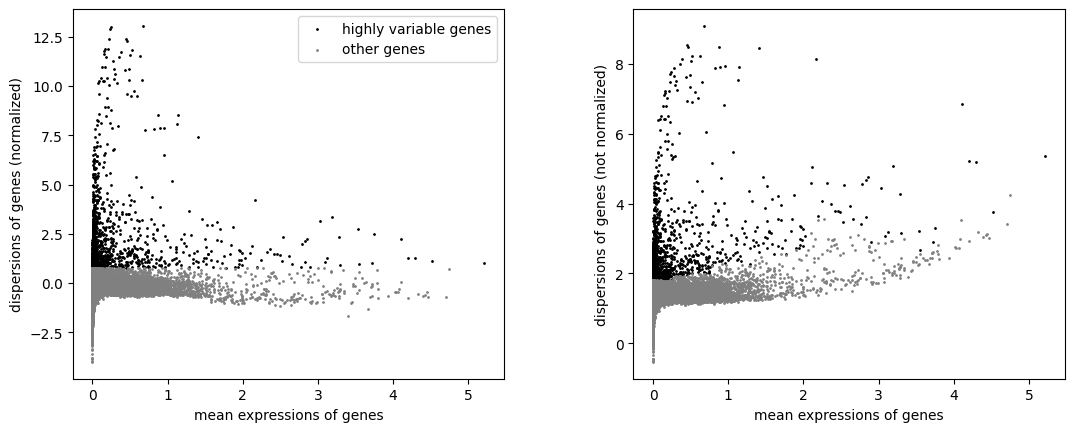

In [98]:
sc.pl.highly_variable_genes(adata)

In [99]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


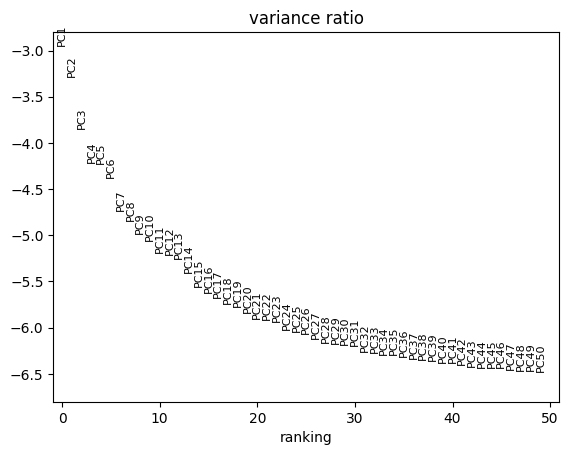

In [100]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

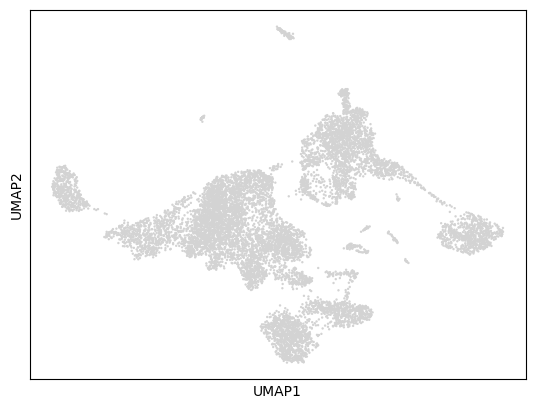

In [101]:
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)
sc.pl.umap(adata)

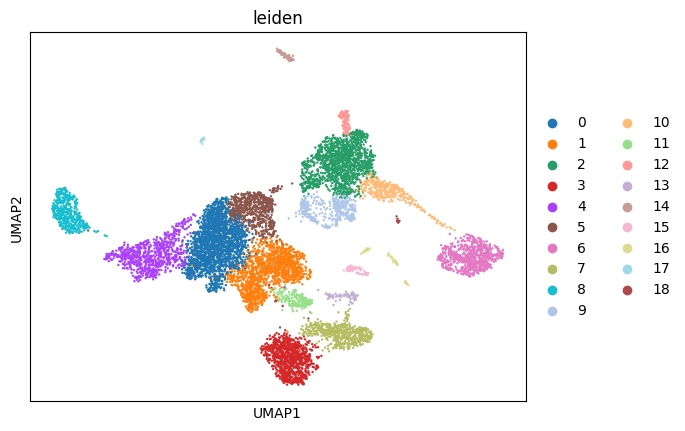

In [102]:
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color=['leiden'])

## Integration

In [58]:
import os

os.listdir('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW')

['.DS_Store',
 'GSM7841477_P1',
 'GSM7841484_P8',
 'GSM7841482_P6',
 'GSM7841479_P3',
 'GSM7841483_P7',
 'GSM7841478_P2',
 'GSM7841480_P4',
 'GSM7841481_P5']

In [126]:
def integrate(data_path):
    pf = data_path.split('/')[-1]
    adata = sc.read_10x_mtx(path=data_path, prefix=pf+'_')
    
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    sc.pp.filter_cells(adata, min_genes=50)
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 0.5)]
    
    adata = sc.read_10x_mtx(path=data_path, prefix=pf+'_')
    adata.obs['Sample'] = pf
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    sc.pp.filter_genes(adata, min_cells=3)
    ribo_path = "/Users/yashasappaji/Desktop/projects/single_cell/Datasets/KEGG_RIBOSOME.v2023.2.Hs.txt"
    ribo_genes = pd.read_table(ribo_path, skiprows=2, header=None)
    
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs['pct_counts_mt'] < 10]
    adata = adata[adata.obs['pct_counts_ribo'] < 40]

    return adata

In [127]:
import os

out = []
for file in os.listdir('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW'):
    if file == '.DS_Store':
        continue
    out.append(integrate('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW/' + file))


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 18.94it/s, v_num=1, train_loss_step=523, train_loss_epoch=567]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 18.79it/s, v_num=1, train_loss_step=523, train_loss_epoch=567]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 298/400:  74%|███████▍  | 298/400 [00:03<00:01, 87.69it/s, v_num=1, train_loss_step=0.318, train_loss_epoch=0.261]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.354. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [04:06<00:00,  1.60it/s, v_num=1, train_loss_step=444, train_loss_epoch=465]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:06<00:00,  1.62it/s, v_num=1, train_loss_step=444, train_loss_epoch=465]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 187/400:  47%|████▋     | 187/400 [00:19<00:21,  9.83it/s, v_num=1, train_loss_step=0.408, train_loss_epoch=0.335]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.342. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [04:47<00:00,  1.53it/s, v_num=1, train_loss_step=418, train_loss_epoch=415]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:47<00:00,  1.39it/s, v_num=1, train_loss_step=418, train_loss_epoch=415]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 248/400:  62%|██████▏   | 248/400 [00:31<00:19,  7.86it/s, v_num=1, train_loss_step=0.189, train_loss_epoch=0.22] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.229. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [00:34<00:00, 11.80it/s, v_num=1, train_loss_step=522, train_loss_epoch=522]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:34<00:00, 11.45it/s, v_num=1, train_loss_step=522, train_loss_epoch=522]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 202/400:  50%|█████     | 202/400 [00:03<00:03, 52.40it/s, v_num=1, train_loss_step=0.243, train_loss_epoch=0.251]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.287. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [08:18<00:00,  1.50s/it, v_num=1, train_loss_step=331, train_loss_epoch=334]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:18<00:00,  1.25s/it, v_num=1, train_loss_step=331, train_loss_epoch=334]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 243/400:  61%|██████    | 243/400 [00:47<00:31,  5.06it/s, v_num=1, train_loss_step=0.172, train_loss_epoch=0.242]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.213. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [00:20<00:00, 19.83it/s, v_num=1, train_loss_step=428, train_loss_epoch=409]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:20<00:00, 19.20it/s, v_num=1, train_loss_step=428, train_loss_epoch=409]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 239/400:  60%|█████▉    | 239/400 [00:03<00:02, 79.08it/s, v_num=1, train_loss_step=0.501, train_loss_epoch=0.296]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.428. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.19it/s, v_num=1, train_loss_step=845, train_loss_epoch=863]      

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.33it/s, v_num=1, train_loss_step=845, train_loss_epoch=863]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 111/400:  28%|██▊       | 111/400 [00:01<00:04, 64.63it/s, v_num=1, train_loss_step=0.255, train_loss_epoch=0.373]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.348. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [08:58<00:00,  1.46s/it, v_num=1, train_loss_step=428, train_loss_epoch=456]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:58<00:00,  1.35s/it, v_num=1, train_loss_step=428, train_loss_epoch=456]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 400/400: 100%|██████████| 400/400 [01:29<00:00,  4.62it/s, v_num=1, train_loss_step=0.174, train_loss_epoch=0.291]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:29<00:00,  4.45it/s, v_num=1, train_loss_step=0.174, train_loss_epoch=0.291]


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

In [128]:
out

[View of AnnData object with n_obs × n_vars = 409 × 11852
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 5154 × 19754
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 6081 × 18924
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_

In [129]:
adata = sc.concat(out)
adata

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 34869 × 10279
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [130]:
adata.write_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373.h5ad')

In [131]:
adata = sc.read_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373.h5ad')
adata

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 34869 × 10279
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [132]:
adata.obs.groupby('Sample').count()

/var/folders/cc/zxztq5d10436scg1c7f92bkr0000gn/T/ipykernel_40121/2340059915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,
GSM7841477_P1,409,409,409,409,409,409,409
GSM7841478_P2,436,436,436,436,436,436,436
GSM7841479_P3,777,777,777,777,777,777,777
GSM7841480_P4,588,588,588,588,588,588,588
GSM7841481_P5,11357,11357,11357,11357,11357,11357,11357
GSM7841482_P6,6081,6081,6081,6081,6081,6081,6081
GSM7841483_P7,10067,10067,10067,10067,10067,10067,10067
GSM7841484_P8,5154,5154,5154,5154,5154,5154,5154


In [133]:
adata.layers['counts'] = adata.X.copy()

In [134]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [135]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", categorical_covariate_keys=['Sample'], continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [136]:
model = scvi.model.SCVI(adata)
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 229/229: 100%|██████████| 229/229 [2:04:38<00:00, 44.85s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.54e+3]   

`Trainer.fit` stopped: `max_epochs=229` reached.


Epoch 229/229: 100%|██████████| 229/229 [2:04:38<00:00, 32.66s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.54e+3]


In [143]:
model.get_latent_representation()

array([[ 1.278893  , -0.8493649 , -1.3821764 , ...,  0.27010053,
        -1.4276804 , -0.9740475 ],
       [ 0.25981045, -0.6775038 , -1.8590598 , ..., -0.7734116 ,
        -1.8791616 , -0.16490549],
       [ 0.55910844,  0.42096668,  0.28100902, ..., -0.2510568 ,
        -2.5278075 , -0.7918591 ],
       ...,
       [ 2.7252057 ,  1.0457582 ,  1.3629723 , ...,  3.8528085 ,
        -0.9671066 ,  0.581654  ],
       [-0.54238874, -1.7715399 , -0.5052577 , ...,  1.310533  ,
         1.0719981 , -0.44112355],
       [ 0.01234031,  2.1886868 ,  2.4824047 , ..., -0.64423484,
         0.41656345, -2.1966364 ]], dtype=float32)

In [144]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression()

In [145]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

In [146]:
for res in [0.02, 0.1, 0.3, 0.5, 0.8, 1.0]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor='igraph')

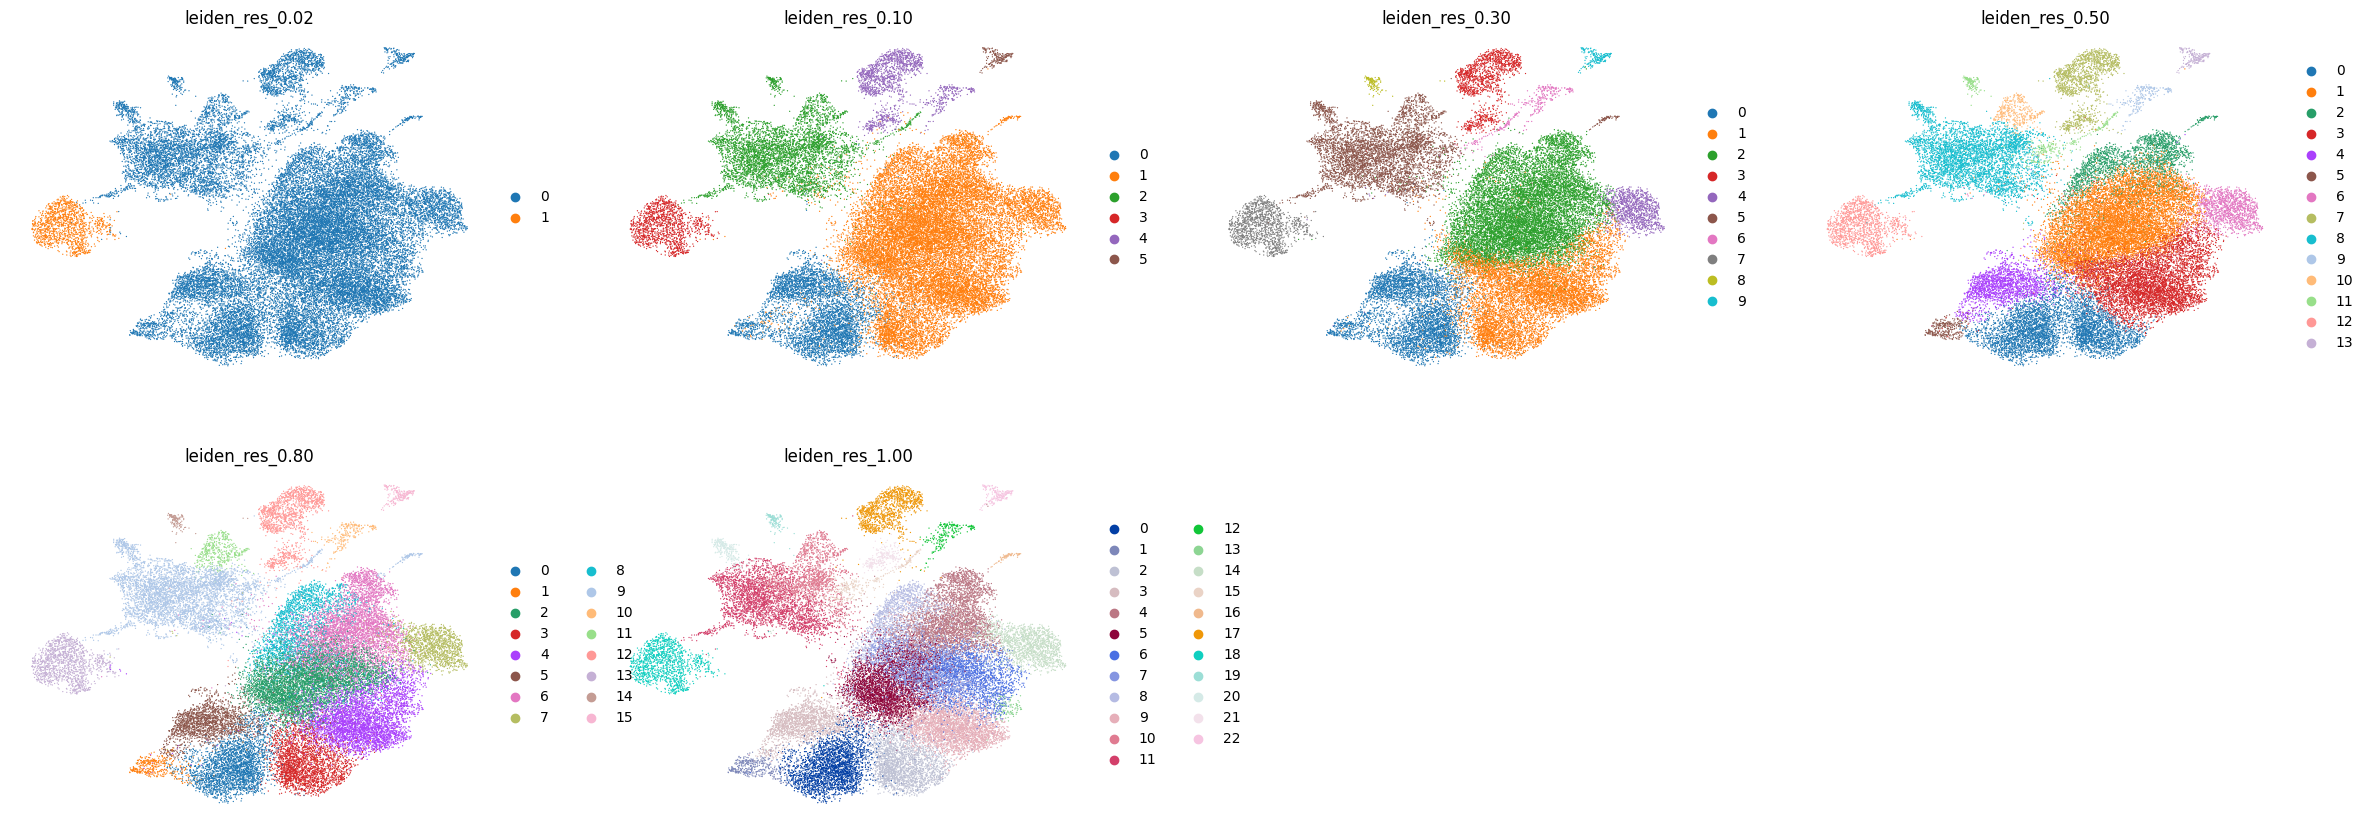

In [147]:
sc.pl.umap(adata, color = ['leiden_res_0.02', 'leiden_res_0.10', 'leiden_res_0.30', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00'], frameon=False)

In [148]:
adata.write_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_integrated_v3.h5ad')

## Cell Type Labeling

In [149]:
adata = sc.read_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_integrated_v3.h5ad')

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [150]:
sc.tl.rank_genes_groups(adata, 'leiden_res_0.80')

In [151]:
markers = sc.get.rank_genes_groups_df(adata, group=None)
markers = markers[(markers['pvals_adj'] < 0.05) & (markers['logfoldchanges'] > 0.5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,NKG7,181.095703,3.993520,0.000000,0.000000
1,0,GNLY,162.612961,5.249425,0.000000,0.000000
2,0,PRF1,138.225555,4.187402,0.000000,0.000000
3,0,CST7,115.753822,2.685417,0.000000,0.000000
4,0,GZMB,113.813782,4.056627,0.000000,0.000000
...,...,...,...,...,...,...
156312,15,KIDINS220,2.339919,0.598238,0.020280,0.049621
156314,15,RNF24,2.339290,1.007903,0.020316,0.049686
156315,15,MTRNR2L8,2.338167,1.026387,0.020376,0.049808
156317,15,TRIP11,2.337829,0.544674,0.020389,0.049829


In [152]:
markers_scvi = model.differential_expression(groupby='leiden_res_0.80')
markers_scvi

DE...: 100%|██████████| 16/16 [01:24<00:00,  5.30s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PRF1,0.9880,0.0120,4.410775,0.003595,0.000319,0.0,0.25,4.250235,4.437430,1.965742,...,11.683301,1.114730,0.982288,0.340136,31.446608,2.751275,True,0 vs Rest,0,Rest
SPON2,0.9866,0.0134,4.299009,0.001002,0.000053,0.0,0.25,4.692742,4.929269,1.989892,...,3.083994,0.137832,0.719093,0.073394,8.522337,0.293700,True,0 vs Rest,0,Rest
AKR1C3,0.9862,0.0138,4.269190,0.000188,0.000020,0.0,0.25,3.411408,3.549865,1.593922,...,0.693939,0.035293,0.415870,0.025900,1.936225,0.071419,True,0 vs Rest,0,Rest
FGFBP2,0.9858,0.0142,4.240211,0.000938,0.000094,0.0,0.25,4.698184,4.671713,2.648154,...,3.180698,0.215720,0.758413,0.069900,9.277061,0.512300,True,0 vs Rest,0,Rest
TTC38,0.9848,0.0152,4.171142,0.000221,0.000025,0.0,0.25,3.604035,3.802889,1.688758,...,0.736446,0.085128,0.466171,0.071553,2.026392,0.211020,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HADHA,0.4766,0.5234,-0.093668,0.000133,0.000129,0.0,0.25,0.068252,0.056252,0.477847,...,0.565657,0.551324,0.398990,0.369646,1.462539,1.207590,False,15 vs Rest,15,Rest
XRN2,0.4742,0.5258,-0.103292,0.000098,0.000099,0.0,0.25,0.008323,0.001432,0.482494,...,0.414142,0.442977,0.287879,0.315912,0.942311,0.991042,False,15 vs Rest,15,Rest
BRMS1,0.4572,0.5428,-0.171620,0.000036,0.000038,0.0,0.25,-0.035481,-0.033121,0.476451,...,0.161616,0.159299,0.156566,0.142713,0.376247,0.372677,False,15 vs Rest,15,Rest
SSB,0.4474,0.5526,-0.211181,0.000111,0.000107,0.0,0.25,0.084073,0.042634,0.467646,...,0.555556,0.496228,0.388889,0.348591,1.241438,1.141502,False,15 vs Rest,15,Rest


In [153]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi['lfc_mean'] > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PRF1,0.9880,0.0120,4.410775,0.003595,0.000319,0.0,0.25,4.250235,4.437430,1.965742,...,11.683301,1.114730,0.982288,0.340136,31.446608,2.751275,True,0 vs Rest,0,Rest
SPON2,0.9866,0.0134,4.299009,0.001002,0.000053,0.0,0.25,4.692742,4.929269,1.989892,...,3.083994,0.137832,0.719093,0.073394,8.522337,0.293700,True,0 vs Rest,0,Rest
AKR1C3,0.9862,0.0138,4.269190,0.000188,0.000020,0.0,0.25,3.411408,3.549865,1.593922,...,0.693939,0.035293,0.415870,0.025900,1.936225,0.071419,True,0 vs Rest,0,Rest
FGFBP2,0.9858,0.0142,4.240211,0.000938,0.000094,0.0,0.25,4.698184,4.671713,2.648154,...,3.180698,0.215720,0.758413,0.069900,9.277061,0.512300,True,0 vs Rest,0,Rest
TTC38,0.9848,0.0152,4.171142,0.000221,0.000025,0.0,0.25,3.604035,3.802889,1.688758,...,0.736446,0.085128,0.466171,0.071553,2.026392,0.211020,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FAM126B,0.9094,0.0906,2.306331,0.000053,0.000024,0.0,0.25,1.146193,1.135535,0.937573,...,0.181818,0.097774,0.151515,0.090133,0.561544,0.260724,True,15 vs Rest,15,Rest
HSPA14,0.9094,0.0906,2.306331,0.000012,0.000006,0.0,0.25,0.955403,0.986195,0.974334,...,0.035354,0.021920,0.035354,0.021517,0.056549,0.056908,True,15 vs Rest,15,Rest
FOXP1,0.9092,0.0908,2.303906,0.000271,0.000131,0.0,0.25,1.216998,1.218976,1.040061,...,1.489899,0.604603,0.666667,0.383692,3.952408,1.587321,True,15 vs Rest,15,Rest
ANXA2,0.9092,0.0908,2.303906,0.000703,0.000309,0.0,0.25,1.271223,1.191305,1.314369,...,3.595958,1.418982,0.808081,0.516426,7.895666,2.801306,True,15 vs Rest,15,Rest


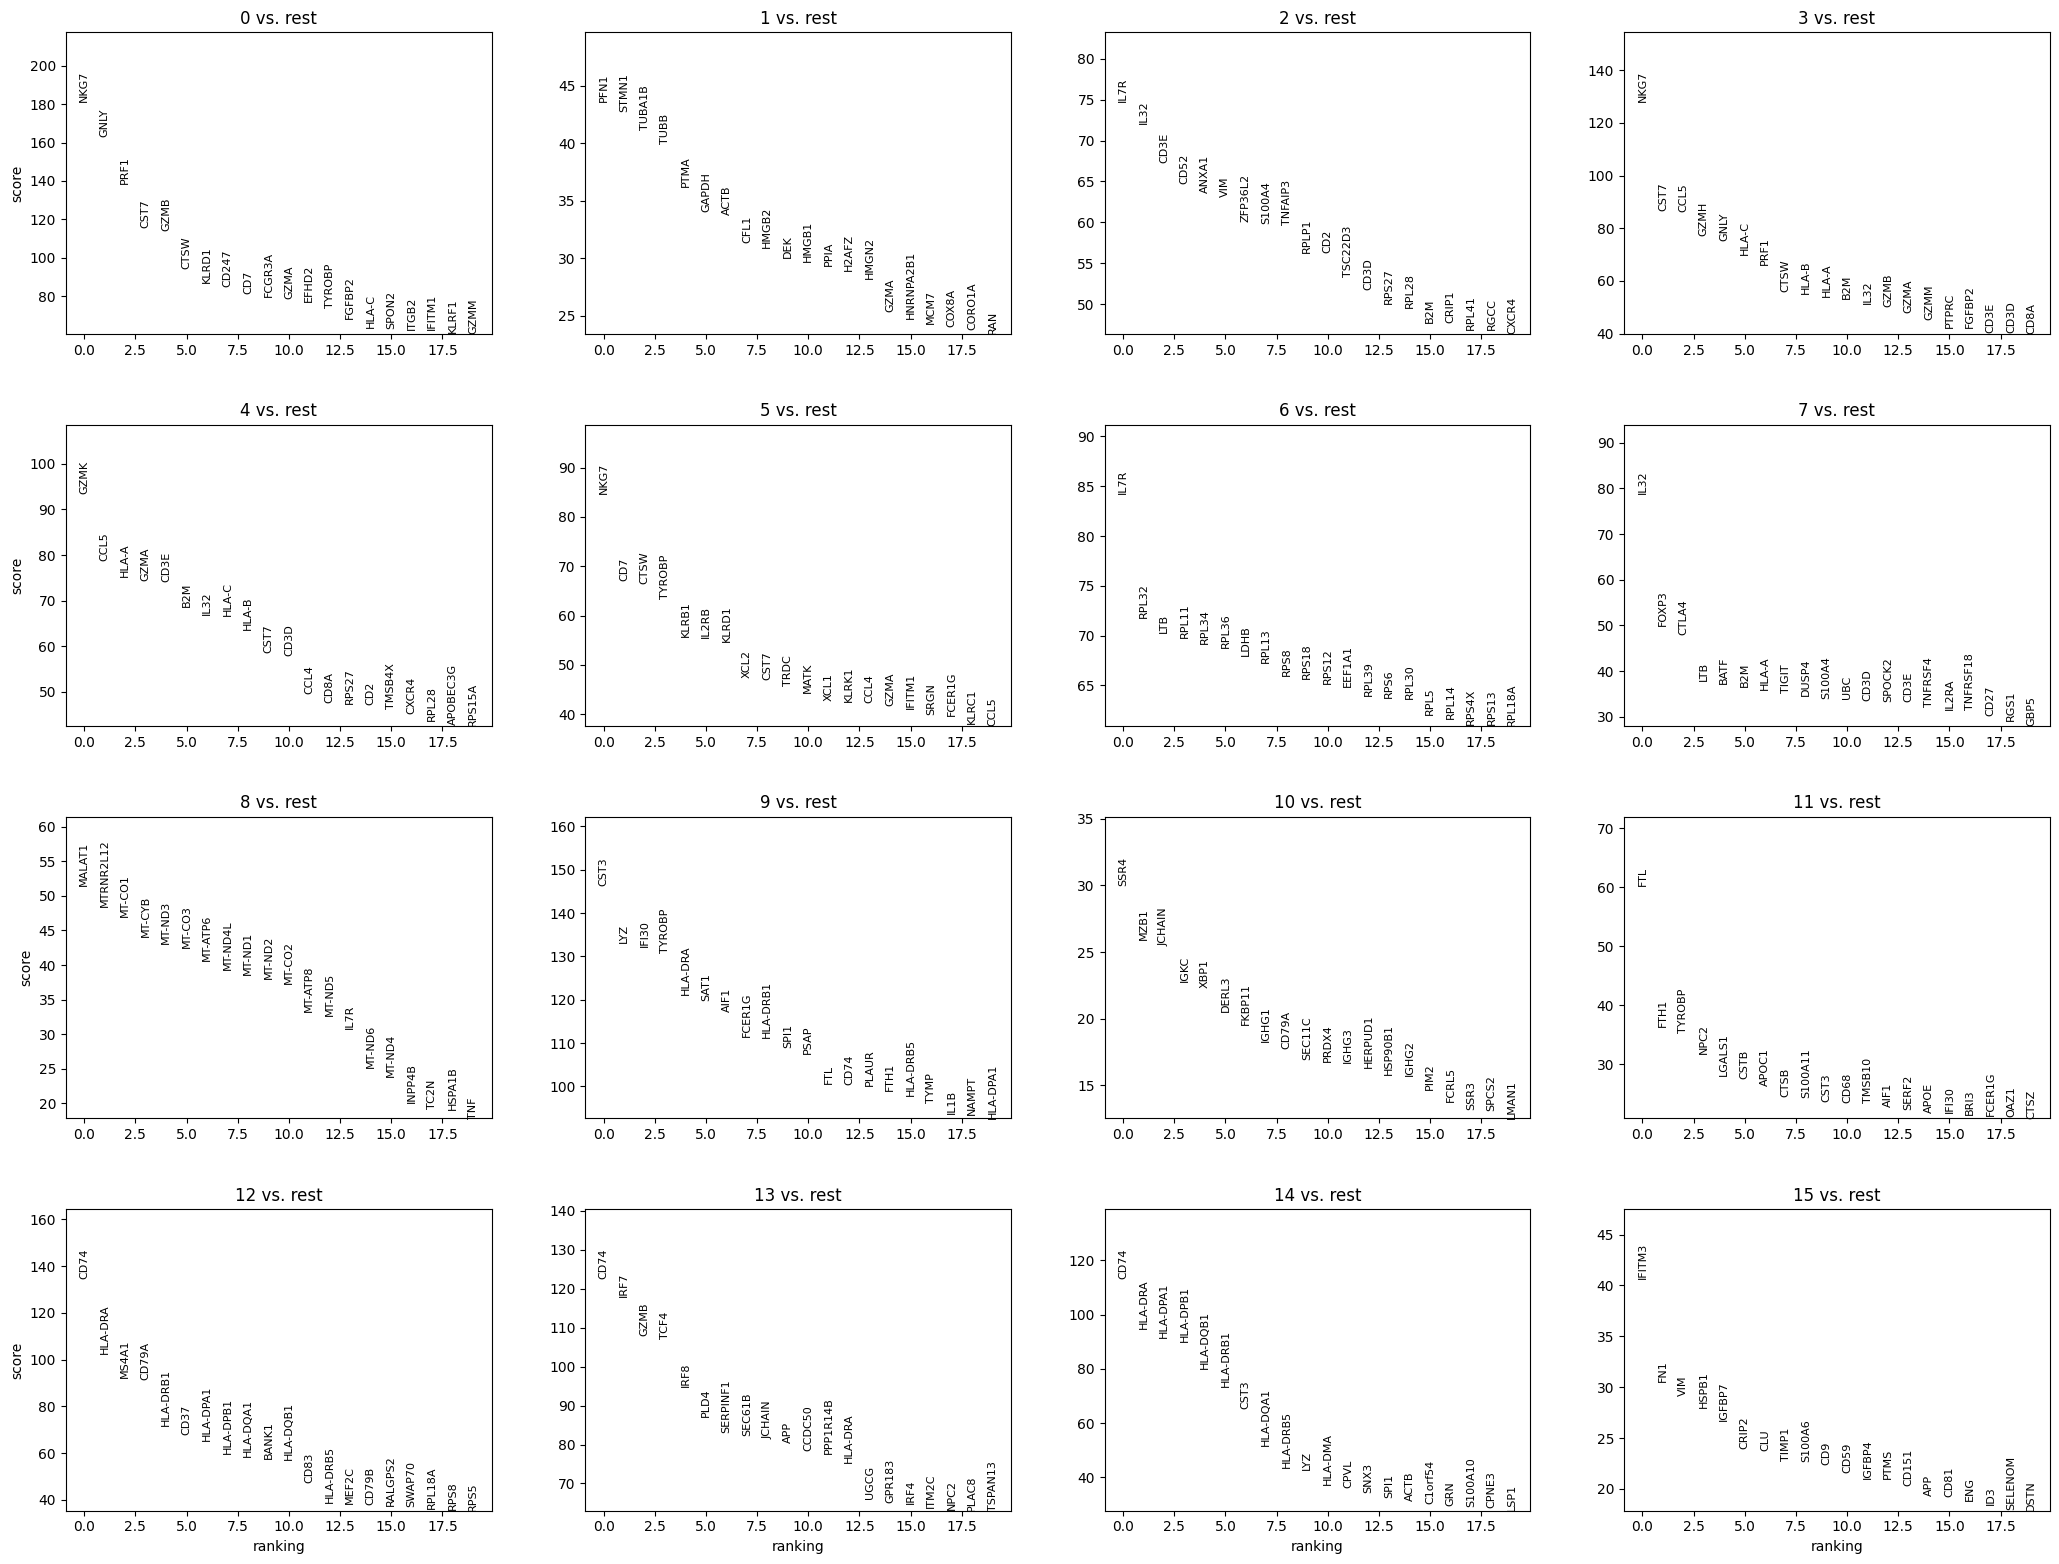

In [154]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

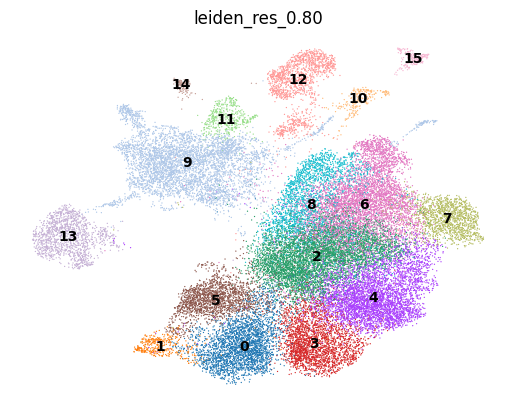

In [155]:
sc.pl.umap(adata, color = ['leiden_res_0.80'], frameon = False, legend_loc = "on data")

In [161]:
markers[markers['names'] == 'IL7R']

,group,names,scores,logfoldchanges,pvals,pvals_adj
20558,2,IL7R,74.715904,2.007940,0.000000e+00,0.000000e+00
61674,6,IL7R,84.201889,2.267926,0.000000e+00,0.000000e+00
82245,8,IL7R,30.730061,1.501906,2.152092e-177,9.964572e-176


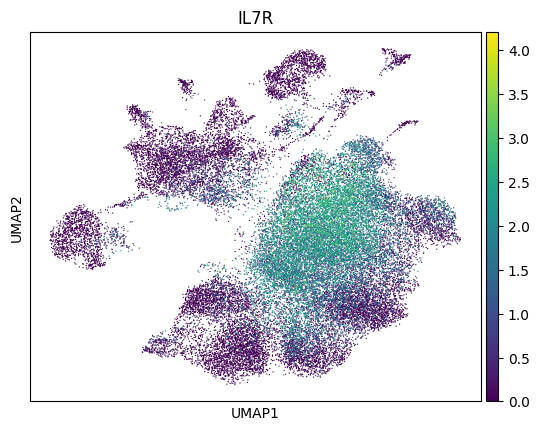

In [162]:
sc.pl.umap(adata, color = ['IL7R'])

In [163]:
cell_types = {
    "0":"NK cells", # CONFIDENT
    "1":"Gamma delta T cells", # CONFIDENT
    "2":"CD4+ T cells", # CONFIDENT
    "3":"CD8+ T cells", # CONFIDENT
    "4":"CD8+ T cells", # CONFIDENT
    "5":"NK T cells", # CONFIDENT
    "6":"CD4+ T cells", # CONFIDENT
    "7":"Other T cells", # CONFIDENT
    "8":"CD4+ T cells", # CONFIDENT
    "9":"Neutrophils", # CONFIDENT
    "10":"Plasma cells", # CONFIDENT
    "11":"Macrophages", # CONFIDENT
    "12":"B cells", # CONFIDENT
    "13":"Plasmacytoid dendritic cells", # CONFIDENT
    "14":"B cells", # CONFIDENT
    "15":"Dendritic cells", # CONFIDENT
}

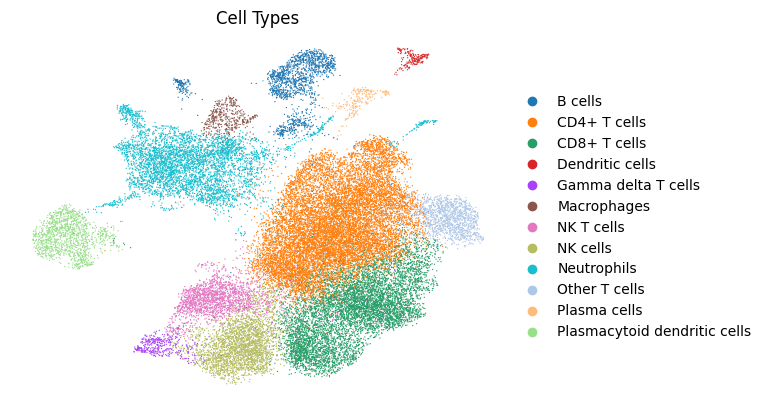

In [164]:
adata.obs['Cell Types'] = adata.obs['leiden_res_0.80'].map(cell_types)
sc.pl.umap(adata, color = ['Cell Types'], frameon = False)

In [165]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [166]:
adata.write_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_final_integrated_v2.h5ad')
model.save('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_model_v2.model')